In [4]:
%matplotlib inline
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale, normalize

In [5]:
def load_mnist(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')    

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:           
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num = struct.unpack(">II", fimg.read(8))        
        rows, cols = struct.unpack(">II", fimg.read(8))        
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])
    return (lbl, img)

In [6]:
def transform_image(img):
    return np.reshape(img, (1, 784))

def transform_label(j, n=10):
    e = np.zeros((n, 1))
    e[j] = 1.0
    return e

In [7]:
%%time

train_labels, train_images = load_mnist(dataset = "training", path = "data/")
test_labels, test_images = load_mnist(dataset = "testing", path = "data/")

train_images = np.array(list(map(transform_image, train_images)))
test_images  = np.array(list(map(transform_image, test_images)))
train_labels = np.array(list(map(transform_label, train_labels)))
test_labels  = np.array(list(map(transform_label, test_labels)))
#print (train_images[100])

CPU times: user 384 ms, sys: 84 ms, total: 468 ms
Wall time: 1.35 s


In [8]:
def binarize_images(imgs):
    return (imgs > 120).astype(int)

def standartize_images(imgs):    
    return imgs / 255

#print (train_images.shape)
train_images = standartize_images(train_images)
test_images  = standartize_images(test_images)



In [9]:
#print (train_images[1000])

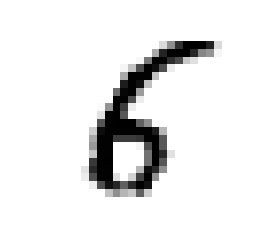

In [10]:
np.random.seed(42)

train_indices = np.random.randint(0, len(train_images), 10)

image = train_images[np.random.randint(0, len(train_images))]
plt.subplot(1, 1, 1)
plt.axis("off")
plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [11]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def sigmoid_der(x):
    s = sigmoid(x)    
    return s * (1 - s)


In [12]:
class NetLayer(object):
    def __init__(self, size, activation, activation_der):
        self.activation = activation
        self.activation_der = activation_der        
        self.w = np.random.normal(loc = 0.0, scale = 0.02, size = size)
        self.b = np.random.normal(loc = 0.0, scale = 0.02, size = (1, size[1]))        
    
    def forward(self, X):
        self.x = X        
        self.y = np.dot(self.x, self.w) + self.b
        self.o = self.activation(self.y)
        return self.o
    
    def error(self, Y):
        return 0.5 * np.sum(((self.o - Y) ** 2))

In [13]:
learn_rate = 0.1

def backprop(x, y):
    t_x = x
    for i in range(net_len):
        layer = net[i]
        t_x = layer.forward(t_x)
            
    #net[-1].sigma = (net[-1].o - y.T)
    net[-1].sigma = - y.T / net[-1].o
    net[-1].delta = net[-1].sigma * layer.activation_der(net[-1].y)
    
    for i in range(2, net_len + 1):
        layer = net[-i]
        layer.sigma = layer.activation_der(layer.y)                
        layer.delta = np.dot(net[-i+1].delta, net[-i+1].w.T) * layer.sigma                    

    for i in range(net_len):    
        layer.w -= learn_rate * np.dot(layer.x.T, layer.delta)
        layer.b -= learn_rate * layer.delta

def train(train_img, train_labels):    
    for (x, y) in zip(train_img, train_labels):
        backprop(x, y)
    
def predict(x):
    for i in range(net_len):
        x = net[i].forward(x)
    return np.argmax(x)

def accuracy(X, y_true):
    y_pred = [predict(x) for x in X]
    y_true = [np.argmax(x) for x in y_true]
    return np.sum([y1 == y2 for (y1,y2) in zip(y_pred, y_true)]) / len(y_true)
        
        

In [14]:
%%time

net = [
    NetLayer((784, 320), sigmoid, sigmoid_der),
    NetLayer((320, 10), sigmoid, sigmoid_der)
]
net_len = len(net)
x1 = train_images
y1 = train_labels

for i in range(12):
    train(x1, y1)
    print ("epoch=%d acc=%f" % (i,accuracy(x1, y1)))

epoch=0 acc=0.861533
epoch=1 acc=0.875483
epoch=2 acc=0.883233
epoch=3 acc=0.887867
epoch=4 acc=0.891267
epoch=5 acc=0.894433
epoch=6 acc=0.896350
epoch=7 acc=0.898200
epoch=8 acc=0.899483
epoch=9 acc=0.900850
epoch=10 acc=0.901967
epoch=11 acc=0.902933
CPU times: user 1h 2min 14s, sys: 1h 42min 56s, total: 2h 45min 11s
Wall time: 41min 45s


In [15]:
%%time

y_true = np.argmax(test_labels, axis=1).T[0]
y_pred = np.array([predict(x) for x in test_images])

CPU times: user 3.3 s, sys: 2.45 s, total: 5.74 s
Wall time: 1.49 s


In [16]:
score = accuracy_score(y_true, y_pred)
print("Error rate: %.1f%%" % (100 * (1 - score)))

Error rate: 9.2%


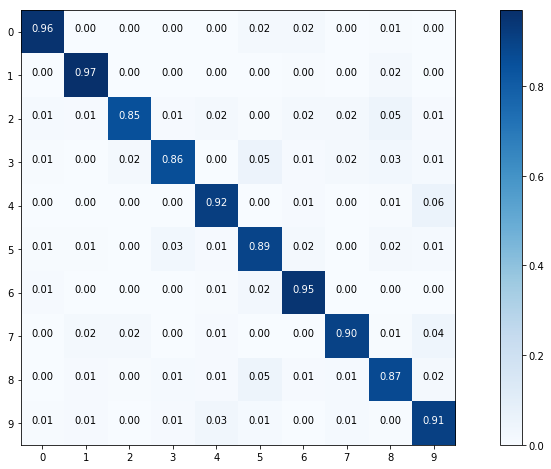

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

# Plot confusion matrix
plt.figure(figsize=(16, 8))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.colorbar()
classes = range(10)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid("off")

# Plot digits of confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "%.2f" % cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


plt.show()

In [18]:
wrong_ones = []
for d in range(10):
    wrong_ones.append([])

for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        img = test_images[i]
        wrong_ones[true].append((img, pred, i))

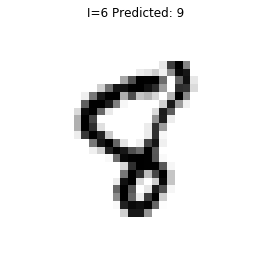

In [27]:
topN = 8

plt.figure(figsize=(4, 4))
img, pred, i = wrong_ones[topN][2]
plt.subplot(1, 1, 1)
plt.axis("off")
plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("I=%d Predicted: %d" % (true, pred))
plt.show()

In [20]:
from PIL import Image
FILENAME = "9.png"
pil_image = Image.open("data/manual/" + FILENAME).resize((28, 28))
img = (255 - np.asarray(pil_image.convert("L")))

In [21]:
img = transform_image(img)
img = standartize_images(np.array([img]))[0]

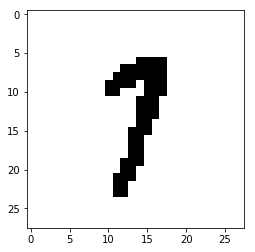

In [22]:
plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")

In [23]:
y_additional_pred = predict(img)
print("Predicted value: %d" % y_additional_pred)

Predicted value: 1
